# FEgrow: An Open-Source Molecular Builder and Free Energy Preparation Workflow

**Authors: Mateusz K Bieniek, Ben Cree, Rachael Pirie, Joshua T. Horton, Natalie J. Tatum, Daniel J. Cole**

* Add a linker + chemical functional group (R-groups) in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Output structures for free energy calculations

## Overview

This is a variation of the first tutorial, where in addition to the R-group we also attach a linker. 

If you're ready to move on to the next stage, please proceed to learning about the fegrow.ChemSpace class. 

In [1]:
import prody
from rdkit import Chem

import fegrow

# Prepare the ligand scaffold

In [2]:
init_mol = Chem.SDMolSupplier('sarscov2/mini.sdf', removeHs=False)[0]

# get the FEgrow representation of the rdkit Mol
scaffold = fegrow.RMol(init_mol)

Show the 2D (with indices) representation of the core. This is used to select the desired growth vector.

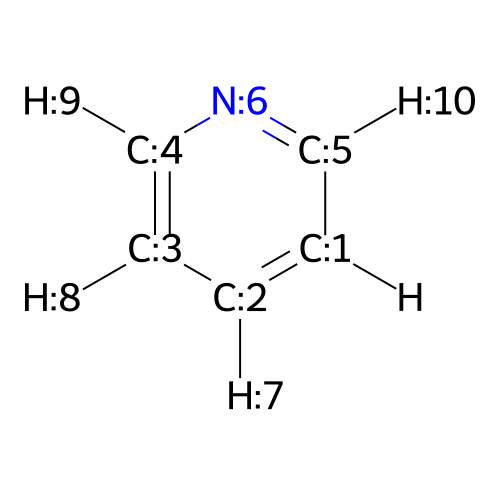

In [3]:
scaffold.rep2D(idx=True, size=(500, 500))

Using the 2D drawing, select an index for the growth vector. In this case, we are selecting the hydrogen atom labelled H:8

In [4]:
attachment_index = 8

# Add RGroup to your scaffold

In this tutorial, we show how one can create an R-group from Smiles

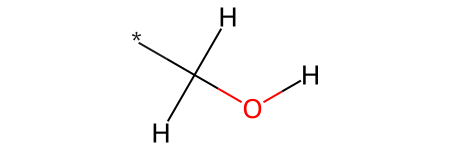

In [5]:
R_group_methanol = Chem.AddHs(Chem.MolFromSmiles('*CO'))
R_group_methanol

# Add a linker

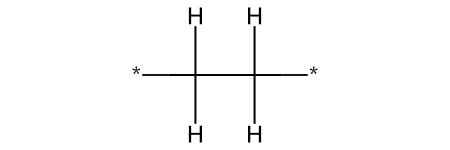

In [6]:
linker_rccr = Chem.AddHs(Chem.MolFromSmiles('*CC*'))
linker_rccr

# Build a new molecule

In [7]:
# we have to specify where the R-group should be attached using the attachment index
rmol_with_linker = fegrow.build_molecule(scaffold, linker_rccr, attachment_index)

/home/dresio/code/fegrow/fegrow/builder.py:220: UserWarning: The linker has two conneting ends specified (* atom). However,they're not given priorities. Choosing a random one.  
  warnings.warn("The linker has two conneting ends specified (* atom). However,"
The R-Group lacks initial coordinates. Defaulting to Chem.rdDistGeom.EmbedMolecule.
[11:56:38] UFFTYPER: Unrecognized atom type: *_ (0)
[11:56:38] UFFTYPER: Unrecognized atom type: *_ (3)


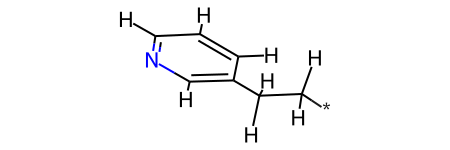

In [8]:
# note that the second connecting point * is left for the future R-group
rmol_with_linker

In [9]:
# use the second connecting point now implicitly
rmol = fegrow.build_molecule(rmol_with_linker, R_group_methanol)

The R-Group lacks initial coordinates. Defaulting to Chem.rdDistGeom.EmbedMolecule.
[11:56:38] UFFTYPER: Unrecognized atom type: *_ (0)


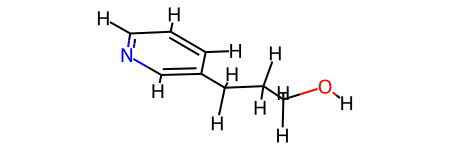

In [10]:
rmol

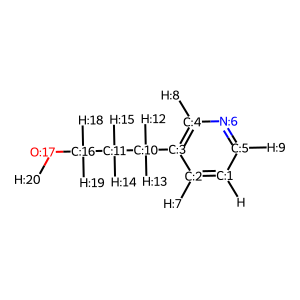

In [11]:
rmol.rep2D()

In [12]:
rmol.rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Once the ligands have been generated, they can be assessed for various ADMET properties, including Lipinksi rule of 5 properties, the presence of unwanted substructures or problematic functional groups, and synthetic accessibility.

In [13]:
rmol.toxicity()

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility,Smiles
ID,,,,,,,,,,
None,137.182,2,1,1.006,True,False,False,False,7.71,[H]OC([H])([H])C([H])([H])C([H])([H])c1c([H])n...


A specified number of conformers (`num_conf`) is generated by using the RDKit [ETKDG algorithm](https://doi.org/10.1021/acs.jcim.5b00654). Conformers that are too similar to an existing structure are discarded. Empirically, we have found that `num_conf=200` gives an exhaustive search, and `num_conf=50` gives a reasonable, fast search, in most cases.

If required, a third argument can be added `flexible=[0,1,...]`, which provides a list of additional atoms in the core that are allowed to be flexible. This is useful, for example, if growing from a methyl group and you would like the added R-group to freely rotate.

In [14]:
rmol.generate_conformers(num_conf=50, 
                          minimum_conf_rms=0.5, 
                          # flexible=[3, 18, 20])
                        )

Generated 19 conformers. 


### Prepare the protein

The protein-ligand complex structure is downloaded, and [PDBFixer](https://github.com/openmm/pdbfixer) is used to protonate the protein, and perform other simple repair:

In [15]:
# get the protein-ligand complex structure
!wget -nc https://files.rcsb.org/download/7L10.pdb

# load the complex with the ligand
sys = prody.parsePDB('7L10.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
rec_final = prody.parsePDB("rec_final.pdb")

File ‘7L10.pdb’ already there; not retrieving.



@> 2609 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 4638 atoms and 1 coordinate set(s) were parsed in 0.03s.


View enumerated conformers in complex with protein:

In [16]:
rmol.rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Any conformers that clash with the protein (any atom-atom distance less than 1 Angstrom), are removed.

Removed 6 conformers. 


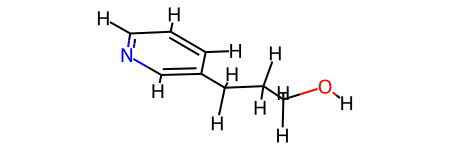

In [17]:
rmol.remove_clashing_confs(rec_final)

In [18]:
rmol.rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Optimise conformers in context of protein

The remaining conformers are optimised using hybrid machine learning / molecular mechanics (ML/MM), using the [ANI2x](https://doi.org/10.1021/acs.jctc.0c00121) neural nework potential for the ligand energetics (as long as it contains only the atoms H, C, N, O, F, S, Cl). Note that the Open Force Field [Parsley](https://doi.org/10.1021/acs.jctc.1c00571) force field is used for intermolecular interactions with the receptor.

`sigma_scale_factor`: is used to scale the Lennard-Jones radii of the atoms.

`relative_permittivity`: is used to scale the electrostatic interactions with the protein.

`water_model`: can be used to set the force field for any water molecules present in the binding site.

In [19]:
# opt_mol, energies
energies = rmol.optimise_in_receptor(
    receptor_file="rec_final.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4,
    water_model = None,
    platform_name = 'CPU', # or e.g. 'CUDA'
)

/home/dresio/software/mambaforge/envs/fegrow/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)


using ani2x


/home/dresio/software/mambaforge/envs/fegrow/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


/home/dresio/software/mambaforge/envs/fegrow/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/13 [00:00<?, ?it/s][W BinaryOps.cpp:594] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer: 100%|█████████████████████| 13/13 [00:22<00:00,  1.73s/it]


The rmol might have no available conformers due to unresolvable steric clashes with the protein. This can be checked using the RDKit's function:

In [20]:
rmol.GetNumConformers()

9

Optionally, display the final optimised conformers. Note that, unlike classical force fields, ANI allows bond breaking. You may occasionally see ligands with distorted structures and very long bonds, but in our experience these are rarely amongst the low energy structures and can be ignored.

Conformers are now sorted by energy, only retaining those within 5 kcal/mol of the lowest energy structure:

In [21]:
final_energies = rmol.sort_conformers(energy_range=5)

In [22]:
rmol.rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Save all of the lowest energy conformers to files and print the sorted energies in kcal/mol (shifted so that the lowest energy conformer is zero).

In [23]:
rmol.to_file(f"1_mini_rmol_best_conformers.pdb") 

In [24]:
print(final_energies)

     ID  Conformer  Energy
0  None          0   0.000
1  None          1   3.105
2  None          2   3.649


The conformers are scored using the [Gnina](https://github.com/gnina/gnina) molecular docking program and convolutional neural network scoring function. *[Note that this step is not supported on macOS].* If unavailable, the Gnina executable is downloaded during the first time it is used. The CNNscores may also be converted to predicted Kd (nM) (see column "Kd").

In [25]:
affinities = rmol.gnina(receptor_file="rec_final.pdb") 
affinities

,ID,Conformer,CNNaffinity,Kd
0,0,0,3.323,474897.6275730648
1,0,1,3.261,548731.6369124426
2,0,2,3.246,567832.1785847507


Predicted binding affinities may be further refined using the structures output by `FEgrow`, using your favourite free energy calculation engine. See our paper for an example using [SOMD](https://github.com/michellab/Sire) to calculate the relative binding free energies of 13 Mpro inhibitors.

In [26]:
# display units
affinities.Kd

0    474897.6275730648
1    548731.6369124426
2    567832.1785847507
Name: Kd, dtype: pint[nanomolar]